In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 데이터 보기
import pandas as pd
import numpy as np
from glob import glob

# 이미지데이터 로딩
from PIL import Image
import cv2
from tqdm import tqdm


# 파일경로 설정
import os
import json

# Others
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt

In [3]:
data_path = '/content/drive/MyDrive/traffic_signal'


train_path = data_path + '/train'
test_path = data_path + '/test'

new_image_directory = data_path + '/new_images'
new_train_image_directory = new_image_directory + '/train'
new_test_image_directory = new_image_directory + '/test'

action_information = pd.read_csv(data_path + '/action_information.csv')
sample_submission = pd.read_csv(data_path + '/sample_submission.csv')

In [4]:
def make_new_dir(path) : 
    if os.path.isdir(path) == False:
        os.makedirs(path)

In [5]:
make_new_dir(new_image_directory)
make_new_dir(new_train_image_directory)
make_new_dir(new_test_image_directory)

In [6]:
train_folders = sorted(glob(train_path + '/*'), key = lambda x : int(x.split('/')[-1].replace('file_','')))
test_folders  = sorted(glob(test_path + '/*'), key = lambda x : int(x.split('/')[-1].replace('file_','')))
train_folders[:5]

['/content/drive/MyDrive/traffic_signal/train/file_0',
 '/content/drive/MyDrive/traffic_signal/train/file_1',
 '/content/drive/MyDrive/traffic_signal/train/file_2',
 '/content/drive/MyDrive/traffic_signal/train/file_3',
 '/content/drive/MyDrive/traffic_signal/train/file_4']

In [7]:
train_folder = train_folders[0]

image_paths = sorted(glob(train_folder + '/*.jpg'), key = lambda x : int(x.split('/')[-1].replace('.jpg','')))
json_path   = glob(train_folder + '/*.json')[0]

(2160, 3840, 3)


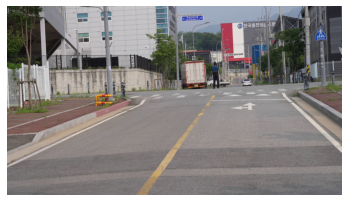

In [8]:
image_path = image_paths[0]
img = Image.open(image_path)
img_arr = np.array(img)
print(img_arr.shape)
plt.imshow(img_arr)
plt.axis('off')
plt.show()

In [9]:
js = json.load(open(json_path))

print("json keys             : ", js.keys())
print("json action info       : ",js.get('action'))
print("json sequence info       : ",js.get('sequence').keys())
print("json info keys : ",js.get('info').keys())

json keys             :  dict_keys(['action', 'sequence', 'info'])
json action info       :  5
json sequence info       :  dict_keys(['image_nums', '2d_pos', 'bounding_box', 'image_height', 'image_width'])
json info keys :  dict_keys(['actor_gender', 'actor_tall_range', 'actor_cloth', 's_height', 'lain_no', 's_dynamic', 's_weather', 's_season', 'direction'])


In [10]:
classes = pd.get_dummies(action_information[['Label']], columns = ['Label']).to_numpy()
classes

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]], dtype=uint8)

In [11]:
image = Image.open(image_path)
bounding_box = js.get('info').get('bounding_box')

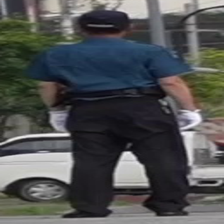

In [12]:
bounding_box = js.get('sequence').get('bounding_box')[0]
bounding_box = [float(x) for x in bounding_box]
image = Image.open(image_path)
image = image.crop(bounding_box) # left top right bottom
image = image.resize((224,224))
image

In [13]:
# train_directories = np.array(sorted(glob(train_path + '/*'), key = lambda x : int(x.split('/')[-1].split('_')[-1])))

# for train_directory in tqdm(train_directories, total = len(train_directories)) : 
#     file_name = train_directory.split('/')[-1]
#     make_new_dir(new_train_image_directory + '/'+file_name)
    
#     image_paths = sorted(glob(train_directory + '/*.jpg'), key = lambda x : int(x.split('/')[-1].replace('.jpg','')))
#     json_path   = glob(train_directory + '/*.json')[0]

#     js = json.load(open(json_path))
#     target = js.get('action')
#     target = classes[target]
#     bounding_boxes = js.get('sequence').get('bounding_box')
#     bounding_boxes = [(float(a),float(b),float(c),float(d)) for a,b,c,d in bounding_boxes] # 실수형태로 변환, (left, top, right, bottom)

#     for image_path, bounding_box in zip(image_paths, bounding_boxes) : 
#         image = Image.open(image_path)
#         image = image.crop(bounding_box) # left top right bottom
#         image = image.resize((224,224))
#         image.save(new_train_image_directory + image_path.split('/train')[1])        

In [14]:
# test_directories = np.array(sorted(glob(test_path + '/*'), key = lambda x : int(x.split('/')[-1].split('_')[-1])))

# for test_directory in tqdm(test_directories, total = len(test_directories)) : 
#     file_name = test_directory.split('/')[-1]
#     make_new_dir(new_test_image_directory + '/'+file_name)
    
#     image_paths = sorted(glob(test_directory + '/*.jpg'), key = lambda x : int(x.split('/')[-1].replace('.jpg','')))
#     json_path   = glob(test_directory + '/*.json')[0]

#     js = json.load(open(json_path))
#     target = js.get('action')
#     target = classes[target]
#     bounding_boxes = js.get('sequence').get('bounding_box')
#     bounding_boxes = [(float(a),float(b),float(c),float(d)) for a,b,c,d in bounding_boxes] # 실수형태로 변환, (left, top, right, bottom)

#     for image_path, bounding_box in zip(image_paths, bounding_boxes) : 
#         image = Image.open(image_path)
#         image = image.crop(bounding_box) # left top right bottom
#         image = image.resize((224,224))
#         image.save(new_test_image_directory + image_path.split('/test')[1])    

In [15]:
# Modeling
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16 # 모델은 가벼운 모델을 사용합니다.
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# GPU 환경 설정
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

# 파일경로 설정
import json

# 데이터 보기
import pandas as pd
import numpy as np
from glob import glob

# 이미지데이터 로딩
from PIL import Image
import cv2
from tqdm import tqdm

# Others
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [16]:
data_path = '/content/drive/MyDrive/traffic_signal'
train_path = data_path + '/train'
test_path = data_path + '/test'

new_image_directory = data_path + '/new_images'
new_train_image_directory = new_image_directory + '/train'
new_test_image_directory = new_image_directory + '/test'

action_information = pd.read_csv(data_path + '/action_information.csv')
sample_submission = pd.read_csv(data_path + '/sample_submission.csv')

classes = pd.get_dummies(action_information[['Label']], columns = ['Label']).to_numpy()

In [17]:
new_train_image_directories = sorted(glob(new_train_image_directory + '/*'), key = lambda x : int(x.split('/')[-1].split('_')[-1]))
new_train_image_directories[:5]

['/content/drive/MyDrive/traffic_signal/new_images/train/file_0',
 '/content/drive/MyDrive/traffic_signal/new_images/train/file_1',
 '/content/drive/MyDrive/traffic_signal/new_images/train/file_2',
 '/content/drive/MyDrive/traffic_signal/new_images/train/file_3',
 '/content/drive/MyDrive/traffic_signal/new_images/train/file_4']

In [18]:
train_answer = []
train_image_directories = sorted(glob(train_path + '/*'), key = lambda x : int(x.split('_')[-1]))
for train_image_directory in train_image_directories : 
    json_path = glob(train_image_directory + '/*.json')[0]
    js = json.load(open(json_path))
    action = js.get('action')
    train_answer.append(action)

In [19]:
images = []
targets = []
stratify = []
for num, (new_train_image_directory, action) in tqdm(enumerate(zip(new_train_image_directories, train_answer)), total = len(new_train_image_directories)) : 
    image_paths = sorted(glob(new_train_image_directory + '/*'), key = lambda x : int(x.split('/')[-1].replace('.jpg','')))
    image_len = len(image_paths)
    for image_path in image_paths : 
        img = image.load_img(image_path, target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img/255
        images.append(img)
        targets.append(classes[action])
        stratify.append(action)

images = np.array(images)
targets = np.array(targets)

100%|██████████| 142/142 [01:10<00:00,  2.02it/s]


In [20]:
print(images.shape)
print(targets.shape)

(22218, 224, 224, 3)
(22218, 6)


In [21]:
train_idx, valid_idx = train_test_split(range(images.shape[0]), test_size = 0.2, stratify = stratify)

X_train = images[train_idx]
y_train = targets[train_idx]

X_valid = images[valid_idx]
y_valid = targets[valid_idx]

print('X_train shape : ', X_train.shape)
print('X_valid shape : ', X_valid.shape)
print('y_train shape : ', y_train.shape)
print('y_valid shape : ', y_valid.shape)

X_train shape :  (17774, 224, 224, 3)
X_valid shape :  (4444, 224, 224, 3)
y_train shape :  (17774, 6)
y_valid shape :  (4444, 6)


In [22]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [ ]:
pre_trained_model = InceptionV3(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = "imagenet")

# pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
     layer.trainable = False
        
# pre_trained_model.summary()
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(6, activation='softmax')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = Adam(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

# checkpoint_path = data_path + 'model/inceptionv3.h5'
# callbacks = [
#     EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=1),
#     ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
# ]

history=model.fit(X_train,y_train,epochs=9,validation_data=(X_valid,y_valid))

last layer output shape:  (None, 12, 12, 768)
Epoch 1/9
556/556 [==============================] - 561s 1s/step - loss: 0.1207 - acc: 0.9611 - val_loss: 0.0058 - val_acc: 0.9984
Epoch 2/9
556/556 [==============================] - 553s 995ms/step - loss: 0.0199 - acc: 0.9930 - val_loss: 0.0157 - val_acc: 0.9941
Epoch 3/9
556/556 [==============================] - 556s 1s/step - loss: 0.0106 - acc: 0.9966 - val_loss: 0.0082 - val_acc: 0.9968
Epoch 4/9
556/556 [==============================] - 557s 1s/step - loss: 0.0164 - acc: 0.9946 - val_loss: 0.0019 - val_acc: 0.9991
Epoch 5/9
556/556 [==============================] - 556s 1s/step - loss: 0.0085 - acc: 0.9970 - val_loss: 6.9886e-04 - val_acc: 0.9998
Epoch 6/9
556/556 [==============================] - 556s 1s/step - loss: 0.0041 - acc: 0.9989 - val_loss: 0.0484 - val_acc: 0.9903
Epoch 7/9
521/556 [===========================>..] - ETA: 29s - loss: 0.0030 - acc: 0.9992

In [ ]:
# import matplotlib.pyplot as plt

# fig, loss_ax = plt.subplots()
# acc_ax = loss_ax.twinx()

# loss_ax.plot(history.history['loss'], 'y', label='train loss')
# loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
# loss_ax.set_xlabel('epoch')
# loss_ax.set_ylabel('loss')
# loss_ax.legend(loc='upper left')

# acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
# acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
# acc_ax.set_ylabel('accuracy')
# acc_ax.legend(loc='upper left')

# plt.show()

In [ ]:
# model = tf.keras.models.load_model(data_path + 'model/inceptionv3.h5')

In [ ]:
new_test_image_directory = new_image_directory + '/test'
new_test_image_directories = sorted(glob(new_test_image_directory + '/*'), key = lambda x : int(x.split('file_')[-1]))

predictions = []
for new_test_image_directory in tqdm(new_test_image_directories, total = len(new_test_image_directories)) :
    image_paths = sorted(glob(new_test_image_directory + '/*.jpg'), key = lambda x : int(x.split('/')[-1].replace('.jpg','')))
    image_len = len(image_paths)
    test_images  = []
    for image_path in image_paths:
        img = image.load_img(image_path, target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img/255
        test_images.append(img)
    prediction = np.mean(model.predict(np.array(test_images)), axis = 0)
    predictions.append(prediction)

In [ ]:
sample_submission.iloc[:,1:] = predictions
display(sample_submission.head())
sample_submission.to_csv('/content/drive/MyDrive/traffic_signal/inceptionv3.csv', index=False)